In [2]:
!apt-get --quiet install -y espeak


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  espeak-data libespeak1 libportaudio2 libsonic0
The following NEW packages will be installed:
  espeak espeak-data libespeak1 libportaudio2 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,382 kB of archives.
After this operation, 3,178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsonic0 amd64 0.2.0-11build1 [10.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak-data amd64 1.48.15+dfsg-3 [1,085 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libespeak1 amd64 1.48.15+dfsg-3 [156 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 espeak amd64 1.48.15+dfsg-3 [64.2 kB]
Fetched 1,382 kB in 0s (4,081 kB/s)
Selecting

In [3]:
!pip --q install num2words pytorch_warmup phonemizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 35.7 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Data source

In [ ]:
# !wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2


# EDA
## STATISTICS


- Total Clips: 13,100
- Total Words: 225,715
- Total Characters: 1,308,674
- Total Duration: 23 hours, 55 minutes, and 17 seconds
- Mean Clip Duration: 6.57 seconds
- Min Clip Duration: 1.11 seconds
- Max Clip Duration: 10.10 seconds
- Mean Words per Clip: 17.23
- Distinct Words: 13,821
- longest text: 331 chars


In [ ]:
# !tar -xvf /content/LJSpeech-1.1.tar.bz2 -C /content/content/MyDrive


In [4]:
import pandas as pd

df = pd.read_csv(r"/content/gdrive/MyDrive/LJSpeech-1.1/metadata.csv", delimiter="|", header=None,)
columns=["filename", "text", "same_text_again"]
df.columns = columns
df.head()

,filename,text,same_text_again
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [ ]:
df.shape

(13100, 3)

In [ ]:
def count_chars(text):
  return len(text)

df["text_length"] = df["text"].apply(count_chars)
df.head()

,filename,text,same_text_again,text_length
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ...",151
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.,30
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...,155
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed...",89
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...,143


In [ ]:
max(df["text_length"])

331

In [ ]:
filenames = df["filename"].tolist()

# preprocessing



## Understanding the dimension of mel spectrogram
The mel-spectrogram of audio data with dimensions 128 x 431 offers a detailed representation of the audio signal over 10 seconds. It splits the audio into 128 frequency bins and 431 time frames, each representing 23.22 milliseconds of audio.

In [5]:
wave_dir = "/content/gdrive/MyDrive/LJSpeech-1.1/wavs"
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
def preprocess_wave_file(file_path, sample_rate=22050, n_mels=128, hop_length=512, n_fft=2048, max_audio_length=10*22050):
    try:
        y, sr = librosa.load(file_path, sr=sample_rate)

        if len(y) < max_audio_length:
            y = np.pad(y, (0, max_audio_length - len(y)), mode='constant')
        elif len(y) > max_audio_length:
            y = y[:max_audio_length]
        print(y)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        print(mel_spectrogram)

        # mel_spectrogram_shifted = np.concatenate([np.zeros([n_mels, 1], np.float32), mel_spectrogram[:, :-1]], axis=1)

        return mel_spectrogram
    except Exception as e:
        print(f"Error occurred while processing {file_path}: {e}")
        return None

mel_spectrogram = preprocess_wave_file(os.path.join(wave_dir, filenames[5]+".wav"))
# print(mel_spectrogram[0].shape, mel_spectrogram[1].shape)
plt.figure(figsize=(10, 4))
mel_spectogram=librosa.display.specshow(mel_spectrogram, sr=22050, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram original')
plt.show()
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mel_spectrogram[1], sr=22050, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel spectrogram shifted')
# plt.show()



NameError: name 'filenames' is not defined

In [ ]:
mel_dir = "/content/gdrive/MyDrive/LJSpeech-1.1/mels"
wave_dir = "/content/gdrive/MyDrive/LJSpeech-1.1/wavs"
# df = pd.read_csv(r"/content/content/MyDrive/LJSpeech-1.1/metadata.csv", delimiter="|", header=None,)
# columns=["filename", "text", "same_text_again"]
# df.columns = columns
# os.makedirs(mel_dir, exist_ok=True)

# for filename in df["filename"]:
#     wav_name = os.path.join(wave_dir, filename + '.wav')
#     mel_spectrogram = preprocess_wave_file(wav_name)
#     np.save(os.path.join(mel_dir, filename + '_mel.npy'), mel_spectrogram)
#     print("saved", filename)

In [6]:
import os

# print(len(os.listdir(mel_dir)))
# print(len(os.listdir(wave_dir)))


# Get the stop token

In [ ]:
# from tqdm import tqdm
# import pandas as pd
# import librosa
# import os
# import time
# import numpy as np

# def get_stop_token(wav_name, sample_rate=22050, n_mels=128, hop_length=512, n_fft=2048, max_audio_length=10*22050):
#     try:
#         y, sr = librosa.load(wav_name, sr=sample_rate)
#         audio_Len = len(y)
#         stop_token = [0 for _ in range(audio_Len)]
#         if audio_Len < max_audio_length:
#             stop_token.extend([1 for _ in range(max_audio_length - audio_Len)])
#         elif audio_Len > max_audio_length:
#             stop_token[-1] = 1
#         return stop_token
#     except Exception as e:
#         print(f"Error occurred while processing {wav_name}: {e}")
#         return None

# stop_token_path = "/content/gdrive/MyDrive/LJSpeech-1.1/stop_tokens.npy"
# wave_dir = "/content/gdrive/MyDrive/LJSpeech-1.1/wavs"
# df = pd.read_csv(r"/content/gdrive/MyDrive/LJSpeech-1.1/metadata.csv", delimiter="|", header=None)
# columns=["filename", "text", "same_text_again"]
# df.columns = columns
# mel_dir = "/content/gdrive/MyDrive/LJSpeech-1.1/mels"  # Ensure mel_dir is defined
# os.makedirs(mel_dir, exist_ok=True)

# stop_tokens = []
# for filename in tqdm(df["filename"], desc='Processing'):
#     wav_name = os.path.join(wave_dir, filename + '.wav')
#     stop_token = get_stop_token(wav_name)
#     stop_tokens.append(stop_token)
#     time.sleep(0.9)


# np.save(stop_token_path, stop_tokens)
# print(f"Stop tokens saved to {stop_token_path}")


Processing:  51%|█████▏    | 6717/13100 [2:16:22<2:43:00,  1.53s/it]

In [ ]:
# # Save the stop tokens to a .npy file
# # np.save(stop_token_path, stop_tokens)
# # print(f"Stop tokens saved to {stop_token_path}")

# # Load the stop tokens from the .npy file
# loaded_stop_tokens = np.load(stop_token_path, allow_pickle=True)
# print(f"Loaded stop tokens from {stop_token_path}")

# print("First stop token from loaded file:", loaded_stop_tokens.shape)


Loaded stop tokens from /content/gdrive/MyDrive/LJSpeech-1.1/stop_tokens.npy
First stop token from loaded file: (1, 220500)


In [ ]:
# from tqdm import tqdm
# import pandas as pd
# import librosa
# import os
# import time
# import numpy as np

# def create_stop_token(mel_spectrogram_db, threshold=-80.0):
#     """
#     Create a stop token for the given mel spectrogram in dB.

#     Parameters:
#     mel_spectrogram_db (numpy.ndarray): 2D array representing the mel spectrogram in dB.
#     threshold (float): dB threshold below which values are considered silence (default is -80.0 dB).

#     Returns:
#     numpy.ndarray: 1D array where 0 indicates audio data and 1 indicates padding.
#     """
#     # Determine the dimensions of the mel spectrogram
#     num_rows, num_cols = mel_spectrogram_db.shape

#     # Initialize the stop token array with zeros
#     stop_token = np.zeros(num_cols)

#     # Iterate over each column from the last to the first
#     for col in range(num_cols - 1, -1, -1):
#         # Check if all values in the column are below the threshold
#         if np.all(mel_spectrogram_db[:, col] <= threshold):
#             stop_token[col] = 1  # Mark as padding
#         else:
#             break  # Stop marking once a non-padding column is found

#     return stop_token

# stop_token_path = "/content/gdrive/MyDrive/LJSpeech-1.1/stop_tokens_from_mel.npy"
# mel_dir = "/content/gdrive/MyDrive/LJSpeech-1.1/mels"
# df = pd.read_csv(r"/content/gdrive/MyDrive/LJSpeech-1.1/metadata.csv", delimiter="|", header=None)
# columns=["filename", "text", "same_text_again"]
# df.columns = columns


# stop_tokens = []
# for filename in tqdm(df["filename"], desc='Processing'):
#     mel_name = os.path.join(mel_dir, filename + '_mel.npy')
#     mel_spectrogram = np.load(mel_name)
#     stop_token = create_stop_token(mel_spectrogram)
#     stop_tokens.append(stop_token)


# np.save(stop_token_path, stop_tokens)
# print(f"\nStop tokens saved to {stop_token_path}")


Processing: 100%|██████████| 13100/13100 [1:19:53<00:00,  2.73it/s]



Stop tokens saved to /content/gdrive/MyDrive/LJSpeech-1.1/stop_tokens_from_mel.npy


In [7]:
stop_token_path = "/content/gdrive/MyDrive/LJSpeech-1.1/stop_tokens_from_mel.npy"
# Load the stop tokens from the .npy file
loaded_stop_tokens = np.load(stop_token_path, allow_pickle=True)
print(f"Loaded stop tokens from {stop_token_path}")

print(loaded_stop_tokens.shape)

Loaded stop tokens from /content/gdrive/MyDrive/LJSpeech-1.1/stop_tokens_from_mel.npy
(13100, 431)


In [ ]:
loaded_stop_tokens[0].tolist().count(0.)

418

# Testing grifinlim mel spectrogram to wave

In [8]:
df = pd.read_csv(r"/content/gdrive/MyDrive/LJSpeech-1.1/metadata.csv", delimiter="|", header=None,)
columns=["filename", "text", "same_text_again"]
df.columns = columns
filenames = df["filename"].tolist()
len(filenames)

13100

[[5.4678168e-08 1.2704531e-08 1.2647321e-08 ... 6.6320434e-09
  1.2323011e-08 9.4641095e-09]
 [9.3553581e-08 4.9014503e-08 6.2460302e-08 ... 6.8758115e-09
  9.2094963e-09 1.0459006e-08]
 [7.5289293e-08 8.2727887e-08 2.0788974e-07 ... 6.0307346e-09
  1.1126455e-08 9.7675086e-09]
 ...
 [8.6074188e-09 1.1038621e-08 8.5179677e-09 ... 9.4943475e-09
  1.1122411e-08 9.0122896e-09]
 [9.8375832e-09 1.0129854e-08 9.6835748e-09 ... 9.2638510e-09
  1.0047513e-08 9.6594368e-09]
 [1.0321868e-08 9.3742134e-09 9.5478958e-09 ... 8.7190317e-09
  1.0534615e-08 9.5835686e-09]]


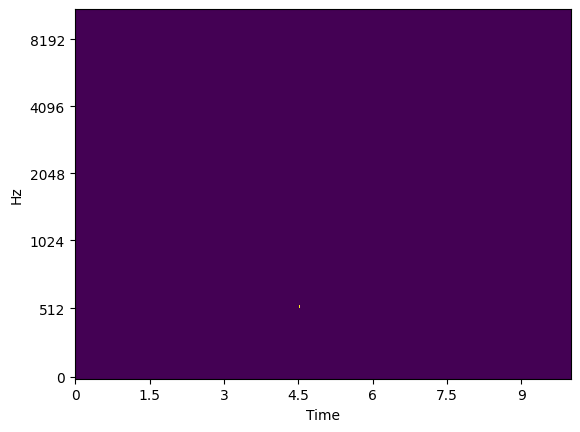

In [9]:
import librosa
import numpy as np
from scipy.io.wavfile import write
from IPython.display import Audio


def inverse_mel_spectrogram(mel_spectrogram, sample_rate=22050, n_fft=2048, hop_length=512):
    # Convert mel spectrogram back to linear spectrogram
    mel_spectrogram = librosa.db_to_power(mel_spectrogram)
    spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram)

    # Convert spectrogram to waveform
    waveform = librosa.griffinlim(spectrogram, n_iter=50, hop_length=hop_length, win_length=n_fft)

    # Ensure waveform is in the range [-1, 1]
    # waveform = np.clip(waveform, -1, 1)

    return waveform

def save_and_play_waveform(waveform, output_path="output.wav", sample_rate=22050):

    return Audio(data=waveform, rate=sample_rate)

# # Example usage:
# mel_spectrogram = preprocess_wave_file(os.path.join(wave_dir, filenames[1]+".wav"))
mel_spectrogram = np.load("/content/gdrive/MyDrive/LJSpeech-1.1/mels/LJ001-0001_mel.npy")
waveform = inverse_mel_spectrogram(mel_spectrogram)
mel_spectrogram_after_inv = librosa.feature.melspectrogram(y=waveform, sr=22050, n_mels=128, hop_length=512, n_fft=2048)
print(mel_spectrogram_after_inv)
mel_spectrogram_after_inv = librosa.power_to_db(mel_spectrogram, ref=np.max)
# print(mel_spectrogram_after_inv)

librosa.display.specshow(mel_spectrogram_after_inv, sr=22050, x_axis='time', y_axis='mel',  cmap='viridis')
save_and_play_waveform(waveform)



In [10]:
waveform.shape

(220160,)

# Preprocess text

In [ ]:
# !pip install eng-to-ipa

In [ ]:
# import eng_to_ipa as ipa
# ipa.convert("The quick brown fox jumped over the lazy dog.")


In [ ]:
# text = df["text"].tolist()
# text = " ".join(text)
# text

In [ ]:
# unique_symbols = set()
# ipa_text = ipa.convert(text)


In [ ]:
# symbols = set(ipa_text)
# len(symbols)

In [11]:
import re
from num2words import num2words
# unique_phons = ['b', ' ', 'u', 'ˌ', 'ɛ', 'v', 'ɾ', ',', 'j', 'ˈ', 'k', 'ʔ', 'd', 'ː', 'a', 'ŋ', 'f', 'ɔ', ';', 'n', 'ɫ', 'θ', 'ʊ', 'ɪ', 'ʃ', 'ʌ', 'h', 'ɑ', 'ɜ', 'ʒ', ':', '?', '!', '-', 'ð', 'i', 'ɚ', 'z', 'x', 'e', 'l', 'w', 'ɐ', 'm', 't', 'ɡ', 'p', 'ə', 's', 'o', 'ᵻ', 'æ', 'r', '.', 'ɹ']
chars = [' ', '!', '"', '$', '&', "'", '(', ')', ',', '-', '.', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~', '£', 'à', 'â', 'è', 'é', 'ê', 'ü', '’', '“', '”']
char2idx = {char:idx for idx,char in enumerate(chars)}
def replace_numbers(match):
  return num2words(int(match.group(0)))

def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'\d+', replace_numbers, text)
  max_length = 331
  length = min(max_length, len(text))
  mat = np.zeros((max_length + 1, len(chars)))
  for i, char in enumerate(text):
    mat[i][char2idx[char]] = 1
  mat[length][char2idx["~"]] = 1 #add stop token
  return mat


preprocess_text("i love the number 69, 120 and 420").shape


(332, 55)

In [12]:
from typing import Union
from phonemizer.phonemize import phonemize
import re
import numpy as np



_vowels = 'iyɨʉɯuɪʏʊeøɘəɵɤoɛœɜɞʌɔæɐaɶɑɒᵻ'
_non_pulmonic_consonants = 'ʘɓǀɗǃʄǂɠǁʛ'
_pulmonic_consonants = 'pbtdʈɖcɟkɡqɢʔɴŋɲɳnɱmʙrʀⱱɾɽɸβfvθðszʃʒʂʐçʝxɣχʁħʕhɦɬɮʋɹɻjɰlɭʎʟ'
_suprasegmentals = 'ˈˌːˑ'
_other_symbols = 'ʍwɥʜʢʡɕʑɺɧ'
_diacrilics = 'ɚ˞ɫ'
_phonemes = sorted(list(
    _vowels + _non_pulmonic_consonants + _pulmonic_consonants + _suprasegmentals + _other_symbols + _diacrilics))
_punctuations = '!,-.:;? \'()'
_alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzäüößÄÖÜ'

all_phonemes = sorted(list(_phonemes) + list(_punctuations))



class Tokenizer:

    def __init__(self, start_token='>', end_token='<', pad_token='/', add_start_end=True, alphabet=None,
                 model_breathing=True):
        if not alphabet:
            self.alphabet = all_phonemes
        else:
            self.alphabet = sorted(list(set(alphabet)))  # for testing
        self.idx_to_token = {i: s for i, s in enumerate(self.alphabet, start=1)}
        self.idx_to_token[0] = pad_token
        self.token_to_idx = {s: [i] for i, s in self.idx_to_token.items()}
        self.vocab_size = len(self.alphabet) + 1
        self.add_start_end = add_start_end
        if add_start_end:
            self.start_token_index = len(self.alphabet) + 1
            self.end_token_index = len(self.alphabet) + 2
            self.vocab_size += 2
            self.idx_to_token[self.start_token_index] = start_token
            self.idx_to_token[self.end_token_index] = end_token
        self.model_breathing = model_breathing
        if model_breathing:
            self.breathing_token_index = self.vocab_size
            self.token_to_idx[' '] = self.token_to_idx[' '] + [self.breathing_token_index]
            self.vocab_size += 1
            self.breathing_token = '@'
            self.idx_to_token[self.breathing_token_index] = self.breathing_token
            self.token_to_idx[self.breathing_token] = [self.breathing_token_index]

    def __call__(self, sentence: str) -> list:
        sequence = [self.token_to_idx[c] for c in sentence]  # No filtering: text should only contain known chars.
        sequence = [item for items in sequence for item in items]
        if self.model_breathing:
            sequence = [self.breathing_token_index] + sequence
        if self.add_start_end:
            sequence = [self.start_token_index] + sequence + [self.end_token_index]
        return sequence

    def decode(self, sequence: list) -> str:
        return ''.join([self.idx_to_token[int(t)] for t in sequence])


class Phonemizer:
    def __init__(self, language: str, with_stress: bool, njobs=4):
        self.language = language
        self.njobs = njobs
        self.with_stress = with_stress
        self.special_hyphen = '—'
        self.punctuation = ';:,.!?¡¿—…"«»“”'
        self._whitespace_re = re.compile(r'\s+')
        self._whitespace_punctuation_re = re.compile(f'\s*([{_punctuations}])\s*')

    def __call__(self, text: Union[str, list], with_stress=None, njobs=None, language=None) -> Union[str, list]:
        language = language or self.language
        njobs = njobs or self.njobs
        with_stress = with_stress or self.with_stress
        # phonemizer does not like hyphens.
        text = self._preprocess(text)
        phonemes = phonemize(text,
                             language=language,
                             backend='espeak',
                             strip=True,
                             preserve_punctuation=True,
                             with_stress=with_stress,
                             punctuation_marks=self.punctuation,
                             njobs=njobs,
                             language_switch='remove-flags')
        return self._postprocess(phonemes)

    def _preprocess_string(self, text: str):
        text = text.replace('-', self.special_hyphen)
        return text

    def _preprocess(self, text: Union[str, list]) -> Union[str, list]:
        if isinstance(text, list):
            return [self._preprocess_string(t) for t in text]
        elif isinstance(text, str):
            return self._preprocess_string(text)
        else:
            raise TypeError(f'{self} input must be list or str, not {type(text)}')

    def _collapse_whitespace(self, text: str) -> str:
        text = re.sub(self._whitespace_re, ' ', text)
        return re.sub(self._whitespace_punctuation_re, r'\1', text)

    def _postprocess_string(self, text: str) -> str:
        text = text.replace(self.special_hyphen, '-')
        text = ''.join([c for c in text if c in all_phonemes])
        text = self._collapse_whitespace(text)
        text = text.strip()
        return text

    def _postprocess(self, text: Union[str, list]) -> Union[str, list]:
        if isinstance(text, list):
            return [self._postprocess_string(t) for t in text]
        elif isinstance(text, str):
            return self._postprocess_string(text)
        else:
            raise TypeError(f'{self} input must be list or str, not {type(text)}')



class TextToTokens:
    def __init__(self, phonemizer: Phonemizer, tokenizer: Tokenizer):
        self.phonemizer = phonemizer
        self.tokenizer = tokenizer

    def __call__(self, input_text: Union[str, list]) -> list:
        phons = self.phonemizer(input_text)
        tokens = self.tokenizer(phons)
        return tokens

    @classmethod
    def default(cls, language: str, add_start_end: bool, with_stress: bool, model_breathing: bool, njobs=1):
        phonemizer = Phonemizer(language=language, njobs=njobs, with_stress=with_stress)
        tokenizer = Tokenizer(add_start_end=add_start_end, model_breathing=model_breathing)
        return cls(phonemizer=phonemizer, tokenizer=tokenizer)

phonemes_file = "/content/content/MyDrive/LJSpeech-1.1/phonemes.csv"

unique_phons = ['b', ' ', 'u', 'ˌ', 'ɛ', 'v', 'ɾ', ',', 'j', 'ˈ', 'k', 'ʔ', 'd', 'ː', 'a', 'ŋ', 'f', 'ɔ', ';', 'n', 'ɫ', 'θ', 'ʊ', 'ɪ', 'ʃ', 'ʌ', 'h', 'ɑ', 'ɜ', 'ʒ', ':', '?', '!', '-', 'ð', 'i', 'ɚ', 'z', 'x', 'e', 'l', 'w', 'ɐ', 'm', 't', 'ɡ', 'p', 'ə', 's', 'o', 'ᵻ', 'æ', 'r', '.', 'ɹ']
phon2idx = {symbol: i for i, symbol in enumerate(unique_phons)}
idx2phon = {i: symbol for i, symbol in enumerate(unique_phons)}

def preprocess_phonemes(symbols):
  max_length = 319
  length = len(symbols)
  mat = np.zeros((max_length + 1, 55))
  for i, char in enumerate(symbols):
    mat[i][phon2idx[char]] = 1
  return mat


def text_to_phonemes(text):
  text_proc = TextToTokens.default('en-us', add_start_end=False,
                                     with_stress=True, model_breathing=False,
                                     njobs=1)

  symbols = text_proc.phonemizer(text)
  return preprocess_phonemes(symbols)

In [14]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class LJSpeechDataset(Dataset):
    """LJSpeech dataset."""

    def __init__(self, filenames, phonemes, mel_dir):
        self.filenames = filenames
        # self.texts = texts
        self.phonemes = phonemes
        self.mel_dir = mel_dir
        self.stop_token_path = "/content/gdrive/MyDrive/LJSpeech-1.1/stop_tokens_from_mel.npy"
        self.stop_tokens = np.load(self.stop_token_path)


    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        mel_name = os.path.join(self.mel_dir, self.filenames[idx] + '_mel.npy')
        mel_spectrogram = np.load(mel_name)
        n_mels = 128
        mel_spectrogram_shifted = np.concatenate([np.zeros([n_mels, 1], np.float32), mel_spectrogram[:, :-1]], axis=1)
        # text = preprocess_text(self.texts[idx])
        phonemes = preprocess_phonemes(self.phonemes[idx])
        stop_token = self.stop_tokens[idx]

        return phonemes, mel_spectrogram, mel_spectrogram_shifted, stop_token

def load_data(metadata_path, mel_dir, test_size=0.1, random_state=42):
    df = pd.read_csv(metadata_path, delimiter="|", header=None, names=["filename", "text", "same_text_again"])
    filenames = df["filename"].tolist()
    # texts = df["text"].tolist()
    phonemes_file = "/content/gdrive/MyDrive/LJSpeech-1.1/phonemes.csv"
    df = pd.read_csv(phonemes_file)
    phonemes = df["phonemes"].tolist()

    # Split the data into training and validation sets
    filenames_train, filenames_val, texts_train, texts_val = train_test_split(
        filenames, phonemes, test_size=test_size, random_state=random_state
    )

    train_dataset = LJSpeechDataset(filenames_train, texts_train, mel_dir)
    val_dataset = LJSpeechDataset(filenames_val, texts_val, mel_dir)

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=128, num_workers=2):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader

# Paths to data
metadata_path = "/content/gdrive/MyDrive/LJSpeech-1.1/metadata.csv"
mel_dir = "/content/gdrive/MyDrive/LJSpeech-1.1/mels"

# Load data and create datasets
train_dataset, val_dataset = load_data(metadata_path, mel_dir)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)

# Example of iterating through the data loader
# text, mel_spectrogram, mel_spectrogram_shifted = next(iter(train_loader))
# text.shape, mel_spectrogram.shape


# Encoder prenet

In [18]:
import torch
import torch.nn as nn

class EncoderPreNet(nn.Module):
    def __init__(self, input_dim=55, embedding_dim=512, output_dim=512, dropout_prob=0.5):
        super(EncoderPreNet, self).__init__()

        # Define the embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # Define the layers
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=output_dim, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv1d(in_channels=output_dim, out_channels=output_dim, kernel_size=3, padding=1, bias=False)
        self.conv3 = nn.Conv1d(in_channels=output_dim, out_channels=output_dim, kernel_size=3, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm1d(output_dim)
        self.batchnorm2 = nn.BatchNorm1d(output_dim)
        self.batchnorm3 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.linear_projection = nn.Linear(output_dim, output_dim)

    def forward(self, x):
        # Convert the one-hot encoded tensor to integer indices
        x = torch.argmax(x, dim=-1).long()

        # Pass the integer indices through the embedding layer
        x = self.embedding(x)  # Shape: (batch_size, sequence_length, embedding_dim)

        # Transpose x to fit Conv1d input format
        x = x.permute(0, 2, 1)  # Shape: (batch_size, embedding_dim, sequence_length)

        # Apply convolution layers with batch normalization, ReLU activation, and dropout
        x = self.dropout(self.relu(self.batchnorm1(self.conv1(x))))
        x = self.dropout(self.relu(self.batchnorm2(self.conv2(x))))
        x = self.dropout(self.relu(self.batchnorm3(self.conv3(x))))

        # Transpose x back to original shape
        x = x.permute(0, 2, 1)  # Shape: (batch_size, sequence_length, output_dim)

        # Apply linear projection
        x = self.linear_projection(x)

        return x

# Create an instance of the EncoderPreNet
encoder_prenet = EncoderPreNet()

# Assuming you have one-hot encoded input tensor of shape (batch_size, sequence_length, input_dim)
# Replace this with your actual one-hot encoded input tensor
input_tensor = torch.randn(64, 320, 55)  # Example random input tensor

# Pass the input tensor through the EncoderPreNet
output_tensor = encoder_prenet(input_tensor)

# Print the shape of the output tensor
print("Shape of output tensor:", output_tensor.shape)

# total_params = sum(p.numel() for p in encoder_prenet.parameters())
# print("Total number of parameters:", total_params)

Shape of output tensor: torch.Size([64, 320, 512])


# Decoder Prenet

In [39]:
import torch
import torch.nn as nn

class DecoderPreNet(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256):
        super(DecoderPreNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

# Create an instance of the DecoderPreNet
decoder_prenet = DecoderPreNet()

# Assuming you have a batch of spectrograms of shape (64, 431, 128)
spectrograms = torch.randn(64, 431, 128)

# Pass the spectrograms through the DecoderPreNet
output = decoder_prenet(spectrograms)

# Print the shape of the output
print("Shape of output:", output.shape)
# total_params = sum(p.numel() for p in decoder_prenet.parameters())
# print("Total number of parameters:", total_params)

Shape of output: torch.Size([64, 431, 256])


In [20]:
import torch
import torch.nn as nn

def get_positional_encoding(d_model, max_len):
    # Create a matrix of shape (max_len, d_model) with positional encodings
    pe = torch.zeros(max_len, d_model)

    # Create a matrix of shape (max_len, 1) with positions 0, 1, ..., max_len-1
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

    # Compute the div_term which is a scaling factor for the frequencies
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

    # Apply the sine function to even indices (2i)
    pe[:, 0::2] = torch.sin(position * div_term)

    # Apply the cosine function to odd indices (2i+1)
    pe[:, 1::2] = torch.cos(position * div_term)

    # Add a batch dimension and register as a buffer
    pe = pe.unsqueeze(0)
    return pe

# # Example usage
# d_model = 512  # Dimensionality of the model
# max_len = 332  # Maximum length of input sequences

# # Create the positional encoding layer
# pos_encoding = get_positional_encoding(d_model, max_len)

# # Sample input (batch_size, sequence_length, d_model)
# # x = torch.zeros(64, 332, d_model)

# # # Add positional encodings to the input
# # x = pos_encoding()
# # for encoding the decoder prenet out
# x = pos_encoding[:,:128,:] + torch.zeros(64, 128, d_model)
# print(x.shape)


# Encoder Attention Block

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size = x.size(0)

        Q = self.query(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attention = torch.nn.functional.softmax(scores, dim=-1)

        context = torch.matmul(attention, V).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.fc(context)

        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # Apply layer normalization before self-attention and feed-forward sub-layers
        x = x +self.self_attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

class Encoder(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=6, d_ff=2048):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])




    def forward(self, x):
        for layer in self.layers:
            x= layer(x)
            return x
d_model = 512
num_heads = 8
num_layers = 3
d_ff = 2048

# Initialize the encoder
encoder = Encoder(d_model, num_heads, num_layers, d_ff)

ff=FeedForward(d_model)
# Sample input (batch_size, sequence_length, d_model)
x = torch.randn(64, 320, d_model)

# Pass the input through the encoder
output = encoder(x)
feedforwardputput=ff(x)
print(output.shape)
print(feedforwardputput.shape)

torch.Size([64, 320, 512])
torch.Size([64, 320, 512])


# Decoder Attention Block

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.query(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.key(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.value(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim=-1)

        context = torch.matmul(attention, V).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.fc(context)

        return output, attention

# class FeedForward(nn.Module):
#     def __init__(self, d_model, d_ff=2048):
#         super(FeedForward, self).__init__()
#         self.fc1 = nn.Linear(d_model, d_ff)
#         self.fc2 = nn.Linear(d_ff, d_model)

#     def forward(self, x):
#         return self.fc2(F.relu(self.fc1(x)))

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.norm1(x)
        x2, _ = self.self_attn(x, x, x, tgt_mask)
        x = x + x2

        x = self.norm2(x)
        x2, _ = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = x + x2

        x = self.norm3(x)
        x2 = self.ff(x)
        x = x + x2

        return x

class Decoder(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=6, d_ff=2048):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x

# Function to create a look-ahead mask
def create_look_ahead_mask(size):
    mask = torch.tril(torch.ones(size, size)).unsqueeze(0).unsqueeze(0)
    return mask

# Example usage
d_model = 512
num_heads = 8
num_layers = 3
d_ff = 2048

# Create look-ahead mask for sequence length 256
target_mask = create_look_ahead_mask(431)

# Initialize the decoder
decoder = Decoder(d_model, num_heads, num_layers, d_ff)

# Sample input (batch_size, sequence_length)
x = torch.randn(64, 431,256)
enc_output = torch.randn(64,320, d_model)  # Encoder output has dimensions (64, 332, d_model)

# Pass the input through the decoder with the look-ahead mask
output = decoder(x, enc_output, tgt_mask=target_mask)
print(output.shape)


RuntimeError: Given normalized_shape=[512], expected input with shape [*, 512], but got input of size[64, 431, 256]

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearProjection(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearProjection, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)



class PostNet(nn.Module):
    def __init__(self, in_channels=128, out_channels=128):
        super(PostNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 512, kernel_size=5, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(512)
        self.conv2 = nn.Conv1d(512, 512, kernel_size=5, padding=2, bias=False)
        self.bn2 = nn.BatchNorm1d(512)
        self.conv3 = nn.Conv1d(512, 512, kernel_size=5, padding=2, bias=False)
        self.bn3 = nn.BatchNorm1d(512)
        self.conv4 = nn.Conv1d(512, 512, kernel_size=5, padding=2, bias=False)
        self.bn4 = nn.BatchNorm1d(512)
        self.conv5 = nn.Conv1d(512, out_channels, kernel_size=5, padding=2, bias=False)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout(x)
        x = self.conv5(x)
        x = x.permute(0, 2, 1)
        return x

# Example usage
decoder_output = torch.randn(64, 431,512)
# Linear projection to mel spectrogram channels
linear_projection = LinearProjection(512, 128)
mel_spectrogram = linear_projection(decoder_output)
print(mel_spectrogram.shape)

# Apply post-processing if needed (e.g., Griffin-Lim algorithm, mel inversion)

# Apply postnet
postnet = PostNet()
refined_mel_spectrogram = postnet(mel_spectrogram)

print(refined_mel_spectrogram.shape)  # Shape: (batch_size, 431, 128)


torch.Size([64, 431, 128])
torch.Size([64, 431, 128])


# stop token

In [27]:
class StopToken(nn.Module):
    def __init__(self, in_features=512, out_features=1):
        super(StopToken, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
      x=self.linear(x)
      return x

stop_token = StopToken()

decoder_output = torch.randn(64, 128,512)

stop_score = stop_token(decoder_output)
stop_score.shape

torch.Size([64, 128, 1])

# Custom loss function to include the loss from both mels predicition and stop token prediciton

In [ ]:
import torch
import torch.nn as nn

class CustomLoss(nn.Module):
  def __init__(self, mel_loss_weight = 0.9):
    super(CustomLoss, self).__init__()
    self.mel_loss_weight = mel_loss_weight
    self.stop_loss_weight = 1 - mel_loss_weight
    self.pos_weight = 5#since the stop token 1 is rare in comparision to 0, we give priority to 1s to balance out
    self.l1_loss_fn = nn.L1Loss()
    self.bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight))

  def forward(self, mel_original, mel_pred, stop_original, stop_pred):
    l1_loss = self.l1_loss_fn(mel_pred, mel_original)
    bce_loss = self.bce_loss_fn(stop_pred, stop_original)
    return (self.mel_loss_weight * l1_loss + self.stop_loss_weight * bce_loss)/2

# Sample data dimensions
batch_size = 64
mel_seq_len = 128
mel_features = 512

# Create sample tensors
mel_original = torch.randn(batch_size, mel_seq_len, mel_features)
mel_pred = torch.randn(batch_size, mel_seq_len, mel_features)
stop_original = torch.zeros(batch_size, mel_seq_len, dtype=torch.float32)
stop_pred = torch.rand(batch_size, mel_seq_len)

# Instantiate the CustomLoss object
custom_loss = CustomLoss()

# Compute the loss
loss = custom_loss(mel_original, mel_pred, stop_original, stop_pred)
print("Computed loss:", loss.item())




Computed loss: 0.5570675730705261


Custom weight initialization if necessary




In [ ]:
import torch.nn.init as init

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d) or isinstance(m, nn.Conv2d):
        init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)
            elif 'bias' in name:
                init.zeros_(param.data)
    elif isinstance(m, nn.Embedding):
        init.normal_(m.weight, mean=0, std=0.01)


# Putting everything into a model

In [ ]:
class TTSModel(nn.Module):
    def __init__(self):
        super(TTSModel, self).__init__()
        self.d_model = 512
        self.num_heads = 8
        self.num_layers = 3
        self.d_ff = 2024
        self.max_char_len = 332
        self.n_mels = 128
        self.out_dim1 = 431

        self.alpha_encoder = nn.Parameter(torch.tensor(1.0)).to(device)  # will be learned later
        self.alpha_decoder = nn.Parameter(torch.tensor(1.0)).to(device)  # will be learned later
        self.positional_encoding = get_positional_encoding(self.d_model, self.max_char_len).to(device)

        self.encoder_prenet = EncoderPreNet().to(device)
        self.decoder_prenet = DecoderPreNet().to(device)
        self.target_mask = create_look_ahead_mask(self.n_mels).to(device)
        self.encoder = Encoder(self.d_model, self.num_heads, self.num_layers, self.d_ff).to(device)
        self.decoder = Decoder(self.d_model, self.num_heads, self.num_layers, self.d_ff).to(device)
        self.linear_projection = LinearProjection(self.d_model, self.out_dim1).to(device)
        self.post_net = PostNet().to(device)

        self.apply(initialize_weights)  # Apply the weight initialization function

    def forward(self, text, audio_spectrogram):
        x = self.encoder_prenet(text)  # torch.Size([64, 332, 512])
        x = x + self.alpha_encoder * self.positional_encoding  # torch.Size([64, 332, 512])
        x = self.encoder(x)  # torch.Size([64, 332, 512])
        speech = self.decoder_prenet(audio_spectrogram)  # torch.Size([64, 128, 512])
        speech = speech + self.alpha_decoder * self.positional_encoding[:, :self.n_mels, :]  # torch.Size([64, 128, 512])
        x = self.decoder(speech, x, tgt_mask=self.target_mask)  # torch.Size([64, 128, 512])
        x = self.linear_projection(x)  # torch.Size([64, 128, 431])
        x = self.post_net(x)  # torch.Size([64, 128, 431])
        return x

    def infer(self, text, max_len=128):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()

        with torch.no_grad():
            text = torch.tensor(preprocess_text(text)).unsqueeze(0).to(device)  # Add batch dimension
            x = self.encoder_prenet(text)  # torch.Size([1, 332, 512])
            x = x + self.alpha_encoder * self.positional_encoding  # torch.Size([1, 332, 512])
            x = self.encoder(x)  # torch.Size([1, 332, 512])

            # Initialize mel spectrogram with zeros
            generated_mel = torch.zeros(1, self.n_mels, self.out_dim1).to(device)

            for t in range(max_len):
                speech = self.decoder_prenet(generated_mel[:, :self.n_mels, :])  # torch.Size([1, 128, 512])
                speech = speech + self.alpha_decoder * self.positional_encoding[:, :self.n_mels, :]  # torch.Size([1, 128, 512])
                x_dec = self.decoder(speech, x, tgt_mask=self.target_mask)  # torch.Size([1, 128, 512])
                projected = self.linear_projection(x_dec)  # torch.Size([1, 128, 431])
                post_output = self.post_net(projected)  # torch.Size([1, 128, 431])
                # print(post_output.shape)

                # Append the last predicted frame to the generated mel spectrogram
                # generated_mel = torch.cat([generated_mel, post_output[:, -1:, :]], dim=1)
                generated_mel=post_output

            return generated_mel.squeeze(0).cpu().numpy()


In [ ]:
model = TTSModel()
model.eval()
with torch.no_grad():

  mel_spectrogram = model(torch.randn(1, 332,55), torch.randn(1,128,431))
  print((mel_spectrogram.shape))


In [ ]:
# model = TTSModel()
# total_params = sum(p.numel() for p in model.parameters())
# print("Total number of parameters:", total_params)

In [ ]:
# mel_spectrogram

In [ ]:
checkpoint_dir = '/content/gdrive/MyDrive/LJSpeech-1.1/checkpoints'
mel_dir = "/content/gdrive/MyDrive/LJSpeech-1.1/mels"

# def make_inference(model, idx_in_lj_dataset):
#   filename = df["filename"].tolist()[idx_in_lj_dataset]
#   text = df["text"].tolist()[idx_in_lj_dataset]
#   original_mel_spectrogram = librosea bla bala (os.path.join(mel_dir, filename + "_mel.npy"))
#   mel_spectrogram = model.infer(text)
#   waveform = inverse_mel_spectrogram(mel_spectrogram)
#   return save_and_play_waveform(waveform)

def make_inference(model, idx_in_lj_dataset, df, mel_dir, epoch_no):

    filename = df["filename"].tolist()[idx_in_lj_dataset]
    text = df["text"].tolist()[idx_in_lj_dataset]

    # Load the original mel spectrogram
    original_mel_path = os.path.join(mel_dir, filename + "_mel.npy")
    original_mel_spectrogram = np.load(original_mel_path)

    # Generate the inferred mel spectrogram
    mel_spectrogram = model.infer(text)
    # print("infered", mel_spectrogram)
    # Convert mel spectrogram to waveform
    waveform = inverse_mel_spectrogram(mel_spectrogram)

    # Save and play the waveform


    # Plot the original and inferred mel spectrograms side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot original mel spectrogram
    ax = axes[0]
    img = librosa.display.specshow(original_mel_spectrogram, sr=22050, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title("Original Mel Spectrogram")
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    print(original_mel_spectrogram.shape)

    # Plot inferred mel spectrogram
    ax = axes[1]
    img = librosa.display.specshow(mel_spectrogram, sr=22050, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f"Inferred Mel Spectrogram{epoch_no}")
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    print(mel_spectrogram.shape)

    # Show the plots
    plt.tight_layout()
    plt.show()
    return Audio(data=waveform, rate=22050)
model = TTSModel().to(device)
epoch_no = "/epoch_130"
# checkpoint = torch.load(f"{checkpoint_dir}{epoch_no}"+".pth",map_location=torch.device('cpu'))
# print(checkpoint.keys())
# model.load_state_dict(checkpoint['model_state_dict'])
make_inference(model, 0, df, mel_dir,epoch_no)


# Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
import pytorch_warmup as warmup

# Assuming the TTSModel, LJSpeechDataset, and data loaders are already defined

# Directory for saving checkpoints and logs
checkpoint_dir = '/content/gdrive/MyDrive/LJSpeech-1.1/checkpoints'
log_file_path = os.path.join(checkpoint_dir, 'training_log.txt')
inference_dir = "infered/"
# # Training function with resume capability
# def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, checkpoint_path=None, warmup_period = 500):
#     # Define loss function and optimizer
#     criterion = nn.CustomLoss()
#     optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.98))
#     milestones = [num_epochs // 3]
#     gamma = 0.1
#     lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
#     warmup_scheduler =  warmup.ExponentialWarmup(optimizer, warmup_period=warmup_period)
#     # # TensorBoard writer
#     # writer = SummaryWriter(checkpoint_dir)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     if torch.cuda.device_count() > 1:
#         model = nn.DataParallel(model)
#     model.to(device)

#     start_epoch = 0

#     # Load checkpoint if provided
#     if checkpoint_path and os.path.isfile(checkpoint_path):
#         checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         train_loss = checkpoint['train_loss']
#         val_loss= checkpoint['val_loss']
#         start_epoch = checkpoint['epoch'] + 1
#         print(f"Resuming training from epoch {start_epoch}")

#     for epoch in range(start_epoch, num_epochs):
#         model.train()
#         train_loss = 0.0

#         # Training loop with tqdm progress bar
#         for texts, mel_spectrograms, mel_spectrograms_shifted in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
#             texts = texts.to(device)
#             mel_spectrograms = mel_spectrograms.to(device)
#             mel_spectrograms_shifted = mel_spectrograms_shifted.to(device)

#             optimizer.zero_grad()
#             outputs = model(texts, mel_spectrograms_shifted)
#             loss = criterion(mel_original, mel_pred, stop_original, stop_pred)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * texts.size(0)

#         train_loss /= len(train_loader.dataset)
#         with warmup_scheduler.dampening():
#             lr_scheduler.step()
#         # Validation
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for texts, mel_spectrograms, mel_spectrograms_shifted in val_loader:
#                 texts = texts.to(device)
#                 mel_spectrograms = mel_spectrograms.to(device)
#                 mel_spectrograms_shifted = mel_spectrograms_shifted.to(device)

#                 outputs = model(texts, mel_spectrograms_shifted)
#                 loss = criterion(mel_original, mel_pred, stop_original, stop_pred)
#                 val_loss += loss.item() * texts.size(0)

#         val_loss /= len(val_loader.dataset)

#         # Log the losses
#         # writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)

#         # Save the model checkpoint
#         checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pth')
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss
#         }, checkpoint_path)

#         # Save losses to log file
#         with open(log_file_path, 'a') as log_file:
#             log_file.write(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')

#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

#     # writer.close()

test_inference = "in being comparatively modern."#second example

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, checkpoint_path=None, warmup_period=500):
    criterion = nn.CustomLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.98))
    milestones = [num_epochs // 3]
    gamma = 0.1
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    warmup_scheduler = warmup.ExponentialWarmup(optimizer, warmup_period=warmup_period)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)

    start_epoch = 0

    if checkpoint_path and os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        train_loss = checkpoint['train_loss']
        val_loss = checkpoint['val_loss']
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch}")

    with open(log_file_path, 'a') as log_file:
        for epoch in range(start_epoch, num_epochs):
            model.train()
            train_loss = 0.0

            for texts, mel_spectrograms, mel_spectrograms_shifted in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                texts = texts.to(device)
                mel_spectrograms = mel_spectrograms.to(device)
                mel_spectrograms_shifted = mel_spectrograms_shifted.to(device)

                optimizer.zero_grad()
                outputs = model(texts, mel_spectrograms_shifted)
                loss = criterion(mel_original, mel_pred, stop_original, stop_pred)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * texts.size(0)

            train_loss /= len(train_loader.dataset)
            with warmup_scheduler.dampening():
                lr_scheduler.step()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for texts, mel_spectrograms, mel_spectrograms_shifted in val_loader:
                    texts = texts.to(device)
                    mel_spectrograms = mel_spectrograms.to(device)
                    mel_spectrograms_shifted = mel_spectrograms_shifted.to(device)

                    outputs = model(texts, mel_spectrograms_shifted)
                    loss = criterion(mel_original, mel_pred, stop_original, stop_pred)
                    val_loss += loss.item() * texts.size(0)

            val_loss /= len(val_loader.dataset)

            checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss
            }, checkpoint_path)

            log_file.write(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')
            log_file.flush()
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

            if epoch % 50 == 0:
                infered = model.infer(test_inference)
                np.save(inference_dir+f"LJ001-0002_epoch{epoch}.npy", infered)

# Example usage
# Instantiate the model
model = TTSModel()

# Load data and create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)

# Train the model from scratch or resume from a checkpoint
# checkpoint_path = os.path.join(checkpoint_dir, 'epoch_1.pth')  # Change this to the desired checkpoint path
train_model(model, train_loader, val_loader, num_epochs=50000, learning_rate=1e-4,checkpoint_path='/content/gdrive/MyDrive/LJSpeech-1.1/checkpoints/epoch_131.pth')


In [ ]:
# from tqdm import tqdm



# epochs = 1
# lr = 0.001 #this might not be the best
# save_step = 2000
# image_step = 500
# batch_size = 2
# checkpoint_path = '/content/content/MyDrive/LJSpeech-1.1/checkpoints'






# # Training Script
# Model=MODEL()


# def main():



#     dataset=LJDatasets()
#     global_step = 0

#     m = nn.DataParallel(Model().cuda())

#     m.train()
#     optimizer = torch.optim.AdamW(m.parameters(),lr, betas=(0.9, 0.98))# may be using lr scheduler is a better idea

#     pos_weight = torch.FloatTensor([5.]).cuda()

#     for epoch in range(epochs):

#         dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_transformer, drop_last=True, num_workers=16)
#         pbar = tqdm(dataloader)
#         for i, data in enumerate(pbar):
#             pbar.set_description("Processing at epoch %d"%epoch)
#             global_step += 1
#             # if global_step < 400000:
#             #     adjust_learning_rate(optimizer, global_step)

#             character, future, present, pos_text, pos_mel, _ = data

#             stop_tokens = torch.abs(pos_mel.ne(0).type(torch.float) - 1)

#             character = character.cuda()
#             future = future.cuda()
#             present = present.cuda()
#             pos_text = pos_text.cuda()
#             pos_mel = pos_mel.cuda()

#             transformer_pred, postnet_pred, stop_preds = m.forward(text,present)

#             mel_loss = nn.L1Loss()(transformer_pred,future)
#             post_mel_loss = nn.L1Loss()(postnet_pred,future)
#             stop_loss = nn.BCEWithLogitsLoss()(stop_preds, stop_tokens)

#             loss = mel_loss+2*post_mel_loss+0.5*stop_loss

#             optimizer.zero_grad()

#             loss.backward()

#             nn.utils.clip_grad_norm_(m.parameters(), 1.)


#             optimizer.step()

#             if global_step % save_step == 0:
#                 torch.save({'model':m.state_dict(),
#                                  'optimizer':optimizer.state_dict()},
#                                 os.path.join(checkpoint_path,'checkpoint_transformer_%d.pth.tar' % global_step))





# if __name__ == '__main__':
#     main()

In [ ]:
#Post Training Script (Mel To Audio Conversion)



In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# wave_dir = "/content/content/MyDrive/LJSpeech-1.1/wavs"
# import librosa
# import librosa.display
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# def preprocess_wave_file(file_path, sample_rate=22050, n_mels=128, hop_length=512, n_fft=2048, max_audio_length=10*22050):
#     try:
#         y, sr = librosa.load(file_path, sr=sample_rate)

#         if len(y) < max_audio_length:
#             y = np.pad(y, (0, max_audio_length - len(y)), mode='constant')
#         elif len(y) > max_audio_length:
#             y = y[:max_audio_length]

#         mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
#         mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

#         # mel_spectrogram_shifted = np.concatenate([np.zeros([n_mels, 1], np.float32), mel_spectrogram[:, :-1]], axis=1)

#         return mel_spectrogram
#     except Exception as e:
#         print(f"Error occurred while processing {file_path}: {e}")
#         return None

# mel_spectrogram = preprocess_wave_file(os.path.join(wave_dir, filenames[5]+".wav"))
# # print(mel_spectrogram[0].shape, mel_spectrogram[1].shape)
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mel_spectrogram, sr=22050, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel spectrogram original')
# plt.show()
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mel_spectrogram[1], sr=22050, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel spectrogram shifted')
# plt.show()

---
unrelated task